<a href="https://colab.research.google.com/github/wonseokb/Genat4_Study/blob/main/5_Working_w_seismic_data(HW_task2%263).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading and visualizing seismic data in Python

In this session:
- we will use the [segpy](https://github.com/sixty-north/segpy) package to read a 3D seismic dataset into a Jupyter notebook
- display seismic cross sections and time slices from this dataset
- think a bit about using colors and colormaps
- read horizon data from surfaces
- create maps from these horizons
- read fault data from faults
- use the [Mayavi](https://docs.enthought.com/mayavi/mayavi/) package to visualize the data in 3D
- create 3D array of seismic facies labels for ML

The goal is that, after going through this notebook, you should be able to read and visualize seismic and horizon data yourself.

We need to install the segpy package first; this can be done by running:

    pip install segpy

Reflection seismology is a method of exploration geophysics that uses the principles of seismology to estimate the properties of the Earth's subsurface from reflected seismic waves. [source](https://en.wikipedia.org/wiki/Reflection_seismology)

<img src = "https://upload.wikimedia.org/wikipedia/commons/0/01/Diagram_of_a_marine_seismic_survey.png" width="600"/>



### Google Colab

You can access files from:
* the drive of the server that you are running the notebook on
* a Google Drive account

You cannot access files on your laptop / workstation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# the drive will be available at '/content/drive/My Drive/'

Mounted at /content/drive


In [2]:
!wget url_to_file # to download a file to the current server that you are running the notebook on

--2023-02-21 17:56:21--  http://url_to_file/
Resolving url_to_file (url_to_file)... failed: Name or service not known.
wget: unable to resolve host address ‘url_to_file’


In [3]:
!unzip filename # unzip the zip file (if necessary)

unzip:  cannot find or open filename, filename.zip or filename.ZIP.


In [4]:
pip install segpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 7.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=3ecab848fa826a6c5db66c3974be6328a30c9afddb66f72bf4896750ea1c1688
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


### Python environments

If a package doesn't work (on Google Colab or on the local computer), you can try creating a new Python environment. See [this page](https://carpentries-incubator.github.io/introduction-to-conda-for-data-scientists/02-working-with-environments/index.html) for an excellent introduction to using Python environments.

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from segpy.reader import create_reader
%matplotlib inline

### Read 3D data

In [ ]:
# this file is available from: https://www.dropbox.com/s/680edyveewojcxn/class2021_16_bit.sgy

# create a segy reader (to be readable by 'segpy', we need a 16-bit seismic volume)
dirname = '/content/drive/My Drive/' # change path to your local path, of course
filename = 'class2021_16_bit.sgy'
fh = open(dirname+filename, 'rb')
reader = create_reader(fh)
print(reader.num_traces()) # number of traces

INFO:segpy.reader:Successfully unpickled reader for /content/drive/My Drive/class2021_16_bit.sgy


697761


In [ ]:
#여기가 데이터 많이 먹음 nt를 100 으로 줄여보자.

# read seismic traces into a numpy array
nt = reader.max_num_trace_samples() # maximum number of samples in a trace
n_inlines = reader.num_inlines() # number of inlines
n_xlines = reader.num_xlines() # number of crosslines
vol = np.zeros((n_inlines, n_xlines, nt)) # array of zeros to store seismic data
for i in range(n_xlines):
    for j in range(n_inlines):
        vol[j, i, :] = reader.trace_samples(j*n_xlines + i)

The data cube that we have read in has 1161 inlines, 601 crosslines, and 2001 time slices:

In [ ]:
np.shape(vol) 

(1161, 601, 2001)

### Visualize seismic sections

In the cell below, we plot inline #500. These are the parameters that go into 'imshow':
- a good default for colors is the 'gray' colormap
- but, for seismic data, it also makes sense to use a diverging colormap that is centered on zero; the 'RdBu' colormap is a good choice
- use vmin and vmax to clip the data so that the colors are not too washed out
- you can use 'aspect' to change the vertical scaling of the section
- to use proper units on the y-axis, we need to convert the sample numbers to two-way-traveltimes. As one sample corresponds to 4 ms, we multiply by 4 to get the tick labels in ms.
- to use proper units on the x-axis, we multiply by 25, as one sample corresponds to 25 m. 

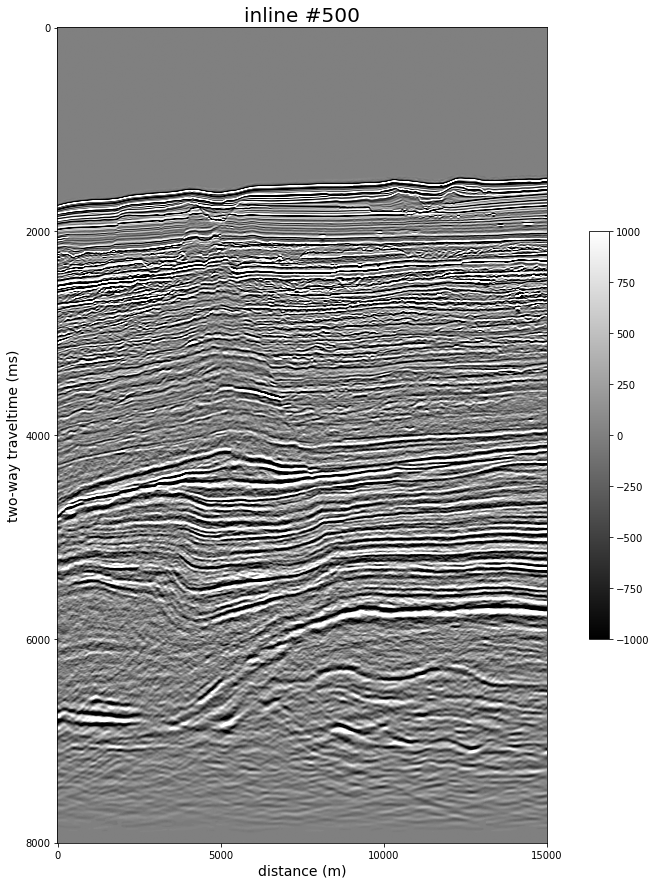

In [ ]:
plt.figure(figsize=(15,15))
im = plt.imshow(vol[500,:,:].T, cmap='gray', vmin=-1000, vmax=1000, aspect=0.5)
yticks = [0, 500, 1000, 1500, 2000]
ytick_labels = [str(4*t) for t in yticks] # use list comprehension to get labels
plt.yticks(ticks = yticks, labels = ytick_labels)
plt.ylabel('two-way traveltime (ms)', fontsize=14)
xticks = [0, 200, 400, 600]
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
plt.xlabel('distance (m)', fontsize=14)
plt.colorbar(im, shrink=0.5) # use the 'shrink' parameter to avoid creating a very large colorbar
plt.title('inline #500', fontsize=20);

Let's plot a section with the red-blue colormap as well:

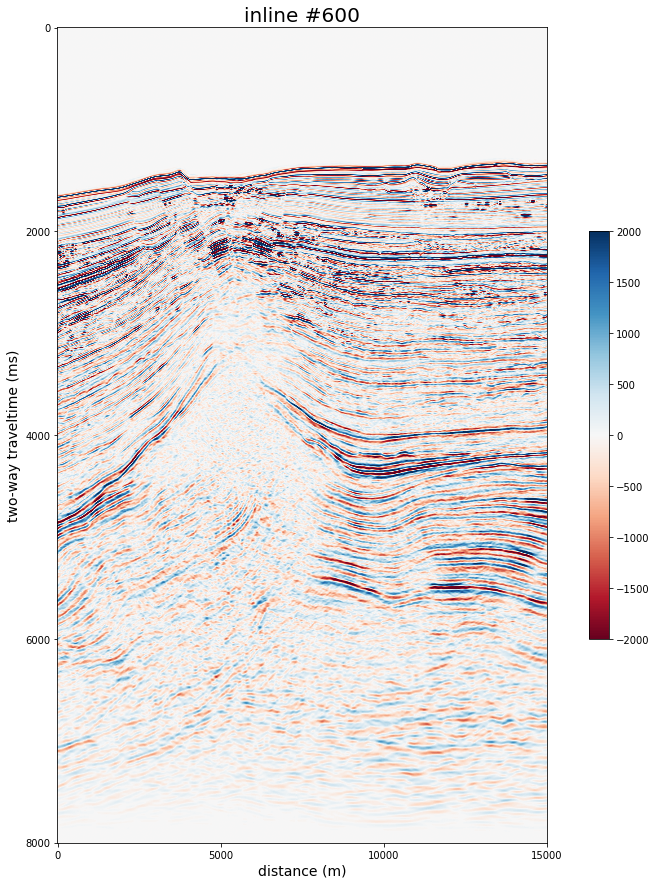

In [ ]:
plt.figure(figsize=(15,15))
im = plt.imshow(vol[600,:,:].T, cmap='RdBu', vmin=-2000, vmax=2000, aspect=0.5) # vmin and vmax should be symmetric about 0
yticks = [0, 500, 1000, 1500, 2000]
ytick_labels = [str(4*t) for t in yticks] # use list comprehension to get labels
plt.yticks(ticks = yticks, labels = ytick_labels)
plt.ylabel('two-way traveltime (ms)', fontsize=14)
xticks = np.arange(0, n_xlines+1, 200)
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
plt.xlabel('distance (m)', fontsize=14)
plt.colorbar(im, shrink=0.5)
plt.title('inline #600', fontsize=20);

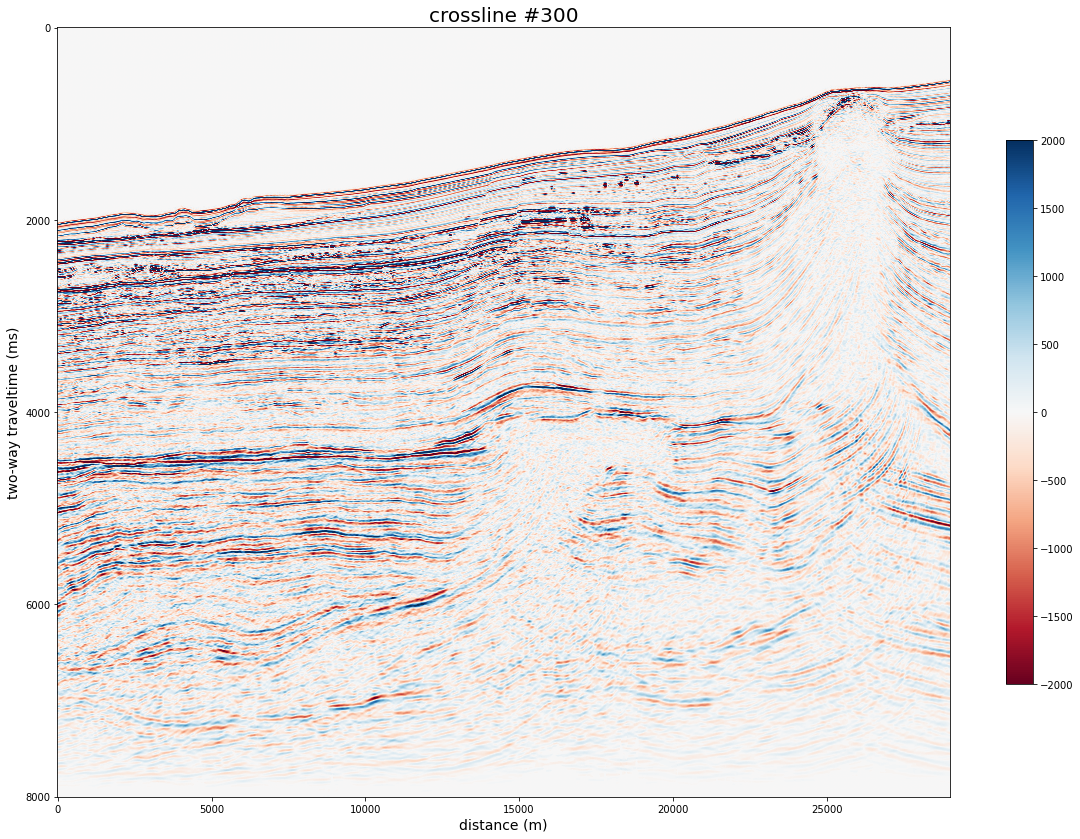

In [ ]:
plt.figure(figsize=(20,20))
im = plt.imshow(vol[:,300,:].T, cmap='RdBu', vmin=-2000, vmax=2000, aspect=0.5)
yticks = [0, 500, 1000, 1500, 2000]
ytick_labels = [str(4*t) for t in yticks] # use list comprehension to get labels
plt.yticks(ticks = yticks, labels = ytick_labels)
plt.ylabel('two-way traveltime (ms)', fontsize=14)
xticks = np.arange(0, n_inlines+1, 200)
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
plt.xlabel('distance (m)', fontsize=14)
plt.colorbar(im, shrink=0.5)
plt.title('crossline #300', fontsize=20);

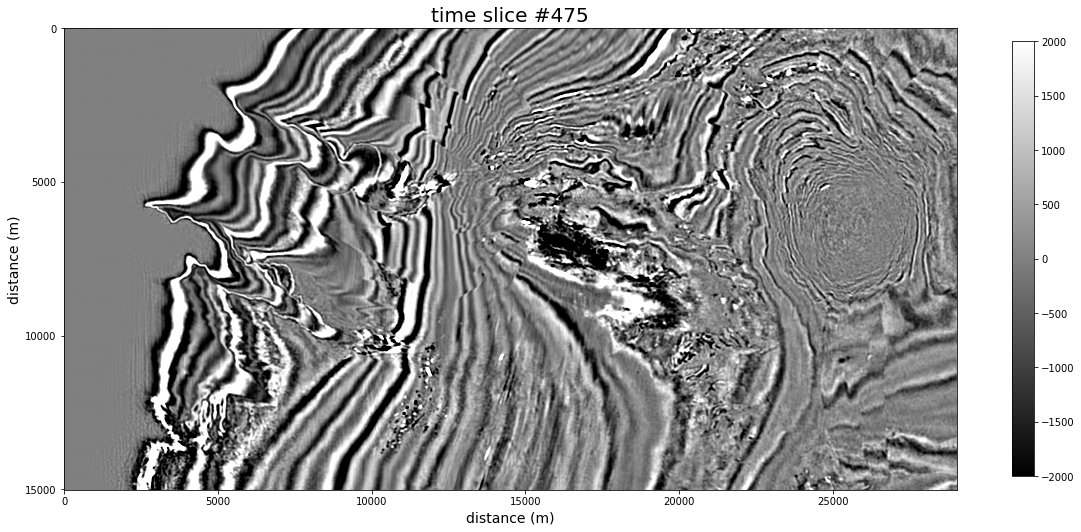

In [ ]:
# plot time slice
plt.figure(figsize=(20,20))
im = plt.imshow(vol[:,:,475].T, cmap='gray', vmin=-2000, vmax=2000, aspect=1)
yticks = np.arange(0, n_xlines+1, 200)
ytick_labels = [str(25*t) for t in yticks]
plt.yticks(ticks = yticks, labels = ytick_labels)
plt.ylabel('distance (m)', fontsize=14)
xticks = np.arange(0, n_inlines+1, 200)
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
plt.xlabel('distance (m)', fontsize=14)
plt.colorbar(im, shrink=0.4)
plt.title('time slice #475', fontsize=20);

Let's display now just one trace as a wiggle trace combined with a so-called variable area display (see [this](https://wiki.aapg.org/Seismic_data_display) page for more detail):

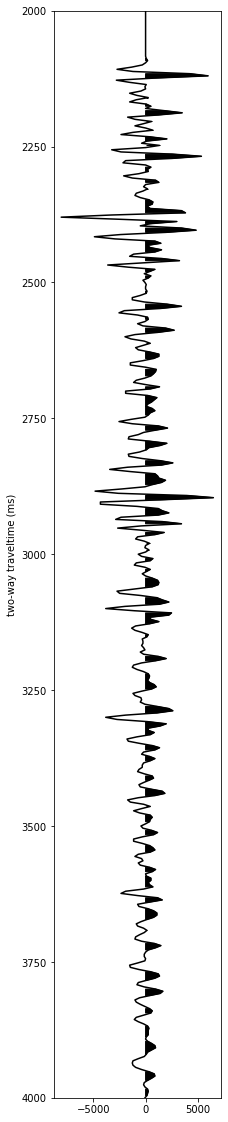

In [ ]:
plt.figure(figsize=(3,20))
tr = vol[0,0,:] # select 'first' trace in volume
twt = np.arange(0, nt) * 4
plt.plot(tr, twt, 'k')
# we use the 'fill_betweenx' function to create the variable area display:
plt.fill_betweenx(twt, tr,  0,  tr> 0.0,  color='k', alpha = 1.0)
plt.ylim(2000, 4000)
plt.ylabel('two-way traveltime (ms)')
plt.gca().invert_yaxis();

### Read and visualize horizons

Read horizon data using pandas:

In [ ]:
url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/seafloor_XY_il_cl.csv'
df = pd.read_csv(url, names=['x', 'y', 'il', 'xl', 'z'])
df[:10]

x           y   il    xl            z
0  414187.21  3203316.25  870  6470  2119.056702
1  414205.46  3203333.33  870  6471  2118.776560
2  414223.72  3203350.41  870  6472  2118.410826
3  414241.97  3203367.50  870  6473  2117.910862
4  414260.23  3203384.58  870  6474  2117.447853
5  414278.48  3203401.66  870  6475  2117.056847
6  414296.74  3203418.74  870  6476  2116.726160
7  414314.99  3203435.82  870  6477  2116.446018
8  414333.25  3203452.91  870  6478  2116.214514
9  414351.50  3203469.99  870  6479  2115.905285

The 'x' and 'y' columns are UTM coordinates in meters (NAD27 datum, UTM zone 16). It is important that this information is known for any project and that it is not lost at any time.

Let's find the x, y coordinates and the inline, crossline numbers for the four corners of the dataset:

In [ ]:
min_il = np.min(np.unique(df['il'])) # minimum inline number
max_il = np.max(np.unique(df['il'])) # maximum inline number
min_xl = np.min(np.unique(df['xl'])) # minimum crossline number
max_xl = np.max(np.unique(df['xl'])) # maximum crossline number

# this assumes that the four corner pixels are defined in the dataframe:

urx = df.loc[df['y'].idxmax()]['x'] # upper right corner x coordinate
ury = df.loc[df['y'].idxmax()]['y'] # upper right corner y coordinate
uril = df.loc[df['y'].idxmax()]['il'] # upper right corner inline number
urxl = df.loc[df['y'].idxmax()]['xl'] # upper right corner crossline number

lrx = df.loc[df['x'].idxmax()]['x'] # lower right corner x coordinate
lry = df.loc[df['x'].idxmax()]['y'] # lower right corner y coordinate
lril = df.loc[df['x'].idxmax()]['il'] # lower right corner inline number
lrxl = df.loc[df['x'].idxmax()]['xl'] # lower right corner crossline number

ulx = df.loc[df['x'].idxmin()]['x'] # upper left corner x coordinate
uly = df.loc[df['x'].idxmin()]['y'] # upper left corner y coordinate
ulil = df.loc[df['x'].idxmin()]['il'] # upper left corner inline number
ulxl = df.loc[df['x'].idxmin()]['xl'] # upper left corner crossline number

llx = df.loc[df['y'].idxmin()]['x'] # lower left corner x coordinate
lly = df.loc[df['y'].idxmin()]['y'] # lower left corner y coordinate
llil = df.loc[df['y'].idxmin()]['il'] # lower left corner inline number
llxl = df.loc[df['y'].idxmin()]['xl'] # lower left corner crossline number

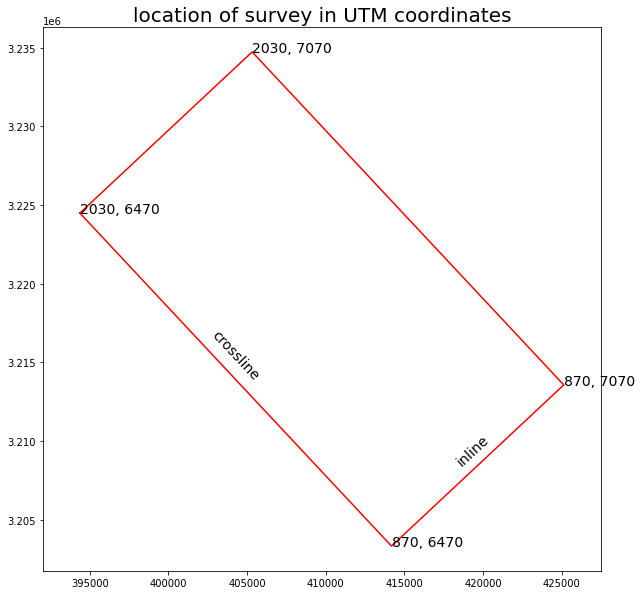

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([ulx, urx, lrx, llx, ulx], [uly, ury, lry, lly, uly], 'r') # plot rectangle defined by corners
plt.text(ulx, uly, str(int(ulil))+', '+str(int(ulxl)), fontsize=14)
plt.text(llx, lly, str(int(llil))+', '+str(int(llxl)), fontsize=14)
plt.text(urx, ury, str(int(uril))+', '+str(int(urxl)), fontsize=14)
plt.text(lrx, lry, str(int(lril))+', '+str(int(lrxl)), fontsize=14)

plt.text((llx + lrx) * 0.5 - 1500, (lly + lry) * 0.5, 'inline', rotation=43.1, fontsize = 14)
plt.text((ulx + llx) * 0.5 - 1700, (uly + lly) * 0.5, 'crossline', rotation=-46.9, fontsize = 14)

plt.axis('equal')
plt.title('location of survey in UTM coordinates', fontsize=20);

Read z-values from dataframe into z array; this takes a while:

In [ ]:
z = np.zeros((n_inlines, n_xlines))
for i in range(len(df)):
    il_ind = df['il'][i]
    xl_ind = df['xl'][i]
    # the inline indices need to be flipped:
    z[max_il - il_ind, xl_ind - min_xl] = df['z'][i]

Check how many z-values are actually defined in the horizon data:

In [ ]:
len(np.unique(df['xl'])) * len(np.unique(df['il'])) - len(df)

63

It looks like 63 values are missing. We can fill these in:

In [ ]:
# fill in the surface where there is no valid data:
zero_row, zero_col = np.where(z == 0) # find locations where z = 0
for i in range(len(zero_row)):
    patch = z[zero_row[i] - 2 : zero_row[i] + 3, zero_col[i] - 2 : zero_col[i] + 3] # patch of 5x5 pixels
    z[zero_row[i], zero_col[i]] = np.mean(patch[patch != 0])  # take the mean of nonzero neighbors

Let's have a quick look at the horizon.

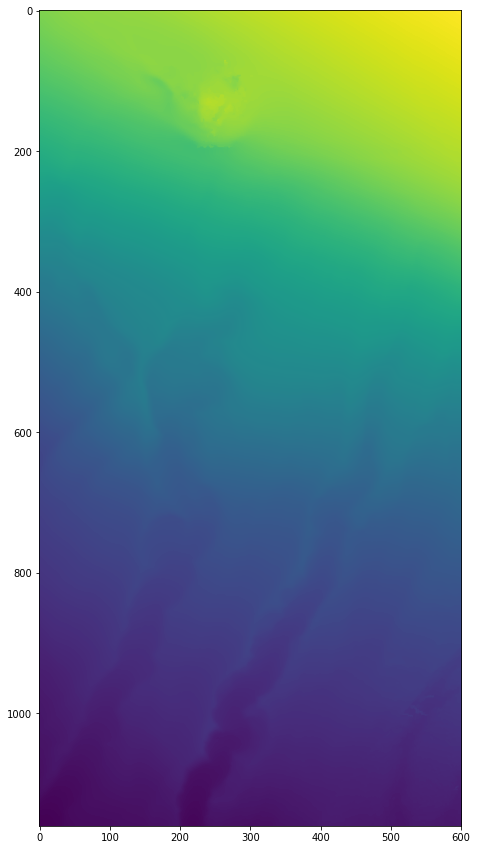

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(z, cmap='viridis_r');

This looks OK but not much morphological detail is visible. To improve the detail, we can use relief shading and contour lines:

In [ ]:
!pip install cmocean
import cmocean

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.1/223.1 KB 6.0 MB/s eta 0:00:00


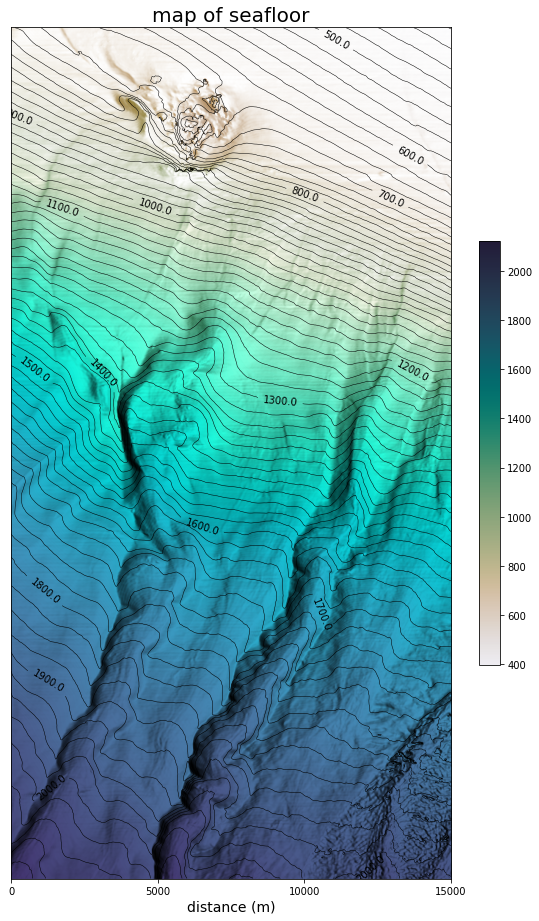

In [ ]:
# display shaded relief image
from matplotlib.colors import LightSource # for shaded relief
import cmocean # for nice colormaps

ls = LightSource(azdeg = 70, altdeg = 45)
cmap = cmocean.cm.rain
rgb = ls.shade(z, cmap, blend_mode='overlay')
fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111)
im = ax.imshow(rgb)
ax.set_xticks([])
ax.set_yticks([])

levels = np.arange(400, np.max(z), 25)
CS = ax.contour(z, levels=levels, colors='k', linewidths=0.5)
# add labels to every 4th contourline:
ax.clabel(CS, levels[::4], inline=True, fmt='%1.1f', fontsize=10)

xticks = np.arange(0, n_inlines+1, 200)
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
ax.set_xlabel('distance (m)', fontsize=14)

# Use a proxy artist for the colorbar
im = ax.imshow(z, cmap=cmap)
im.remove()
fig.colorbar(im, shrink=0.4, ax=ax)
plt.tight_layout()
plt.title('map of seafloor', fontsize=20);

### A few good resources for working with colormaps:

https://matplotlib.org/stable/tutorials/colors/colormaps.html

https://matplotlib.org/stable/tutorials/colors/colors.html

https://matplotlib.org/cmocean/

https://bids.github.io/colormap/

https://matplotlib.org/stable/gallery/specialty_plots/advanced_hillshading.html

https://www.climate-lab-book.ac.uk/2014/end-of-the-rainbow/

https://rdcu.be/b9lm1

In [ ]:
# read data for another horizon
url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/below_Fuji_XY_il_cl.csv'
df = pd.read_csv(url, names=['x', 'y', 'il', 'xl', 'z'])
df[:10]

x           y   il    xl            z
0  414187.21  3203316.25  870  6470  2427.199125
1  414205.46  3203333.33  870  6471  2427.102804
2  414223.72  3203350.41  870  6472  2427.065134
3  414241.97  3203367.50  870  6473  2427.044153
4  414260.23  3203384.58  870  6474  2426.855803
5  414278.48  3203401.66  870  6475  2427.333117
6  414296.74  3203418.74  870  6476  2428.798199
7  414314.99  3203435.82  870  6477  2429.664850
8  414333.25  3203452.91  870  6478  2429.777861
9  414351.50  3203469.99  870  6479  2429.334164

In [ ]:
# check the number of missing z-values:
len(np.unique(df['xl'])) * len(np.unique(df['il'])) - len(df)

1819

In [ ]:
# read z-values from dataframe into z array; this takes a while:
base_Fuji = np.zeros((n_inlines, n_xlines))
for i in range(len(df)):
    il_ind = df['il'][i]
    xl_ind = df['xl'][i]
    # the inline indices need to be flipped:
    base_Fuji[max_il - il_ind, xl_ind - min_xl] = df['z'][i]

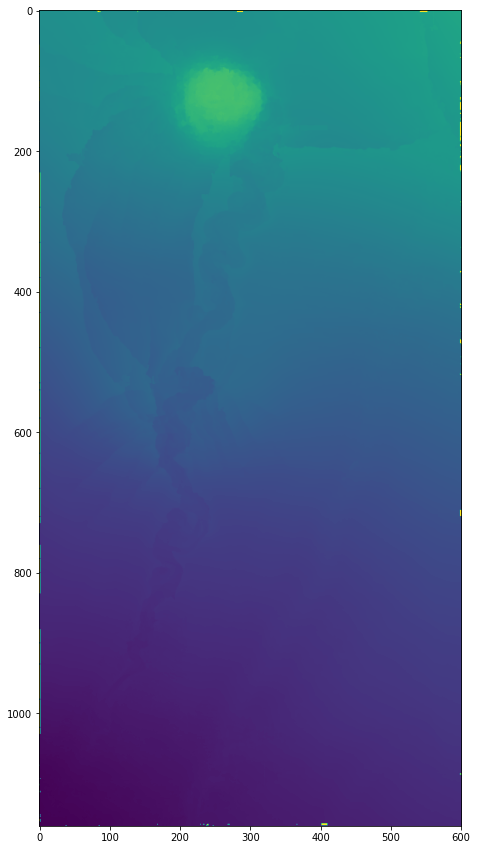

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(base_Fuji, cmap='viridis_r')

In [ ]:
# fill in and despike the surface:
zero_row, zero_col = np.where(base_Fuji==0) # find locations where z = 0
for i in range(len(zero_row)):
    if zero_col[i] == 0:
        patch = base_Fuji[zero_row[i]-2 : zero_row[i]+3, zero_col[i] : zero_col[i]+3]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    elif zero_col[i] == 1:
        patch = base_Fuji[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-1 : zero_col[i]+3]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    elif zero_col[i] == n_xlines-1:
        patch = base_Fuji[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-3 : zero_col[i]]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    elif zero_col[i] == n_xlines-2:
        patch = base_Fuji[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-3 : zero_col[i]+1]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    elif zero_row[i] == 0:
        patch = base_Fuji[zero_row[i] : zero_row[i]+3, zero_col[i]-2 : zero_col[i]+3]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    elif zero_row[i] == 1:
        patch = base_Fuji[zero_row[i]-1 : zero_row[i]+3, zero_col[i]-2 : zero_col[i]+3]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    elif zero_row[i] == n_inlines-1:
        patch = base_Fuji[zero_row[i]-3 : zero_row[i], zero_col[i]-2 : zero_col[i]+3]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    elif zero_row[i] == n_inlines-2:
        patch = base_Fuji[zero_row[i]-3 : zero_row[i]+1, zero_col[i]-2 : zero_col[i]+3]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    else:
        patch = base_Fuji[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-2 : zero_col[i]+3]
        base_Fuji[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors

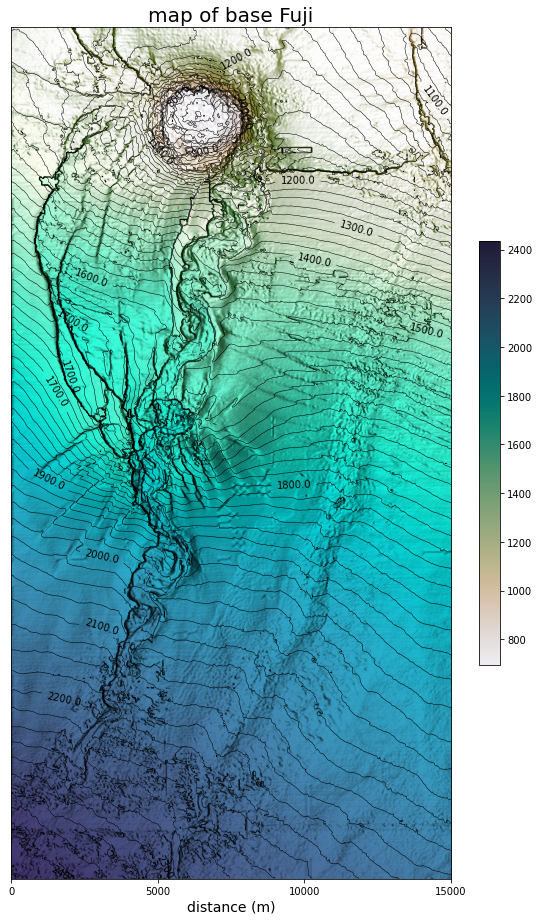

In [ ]:
# display shaded relief image
ls = LightSource(azdeg = 70, altdeg = 45)
cmap = cmocean.cm.rain
rgb = ls.shade(base_Fuji, cmap, blend_mode='overlay')
fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111)
im = ax.imshow(rgb)
ax.set_xticks([])
ax.set_yticks([])

levels = np.arange(700, np.max(base_Fuji), 25)
CS = ax.contour(base_Fuji, levels=levels, colors='k', linewidths=0.5)
# add labels to every 4th contourline:
ax.clabel(CS, levels[::4], inline=True, fmt='%1.1f', fontsize=10)

xticks = np.arange(0, n_inlines+1, 200)
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
ax.set_xlabel('distance (m)', fontsize=14)

# Use a proxy artist for the colorbar
im = ax.imshow(base_Fuji, cmap=cmap)
im.remove()
fig.colorbar(im, shrink=0.4, ax=ax)
plt.tight_layout()
plt.title('map of base Fuji', fontsize=20);

### An optional detour: If you want to make a properly georeferenced map

In [ ]:
url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/seafloor_XY_il_cl.csv'
df = pd.read_csv(url, names=['x', 'y', 'il', 'xl', 'z'])
df[:10]

x           y   il    xl            z
0  414187.21  3203316.25  870  6470  2119.056702
1  414205.46  3203333.33  870  6471  2118.776560
2  414223.72  3203350.41  870  6472  2118.410826
3  414241.97  3203367.50  870  6473  2117.910862
4  414260.23  3203384.58  870  6474  2117.447853
5  414278.48  3203401.66  870  6475  2117.056847
6  414296.74  3203418.74  870  6476  2116.726160
7  414314.99  3203435.82  870  6477  2116.446018
8  414333.25  3203452.91  870  6478  2116.214514
9  414351.50  3203469.99  870  6479  2115.905285

Let's find the angle of the crossline direction relative to the E-W (horizontal) direction:

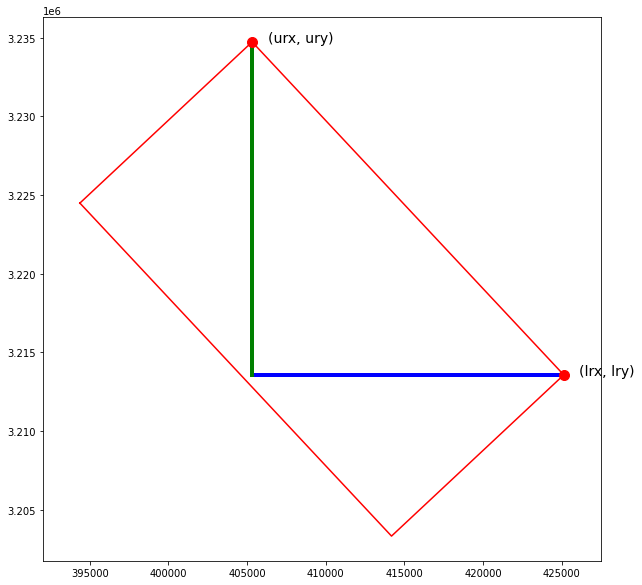

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([ulx, urx, lrx, llx, ulx], [uly, ury, lry, lly, uly], 'r')
plt.plot([lrx, urx], [lry, lry], 'b', linewidth = 4)
plt.plot([urx, urx], [lry, ury], 'g', linewidth = 4)
plt.plot(urx, ury, 'ro', markersize=10)
plt.text(urx+1000, ury, '(urx, ury)', fontsize=14)
plt.plot(lrx, lry, 'ro', markersize=10)
plt.text(lrx+1000, lry, '(lrx, lry)', fontsize=14)
plt.axis('equal');

In [ ]:
np.rad2deg(np.arctan2(ury - lry, lrx - urx))

46.89907760788802

So the angle relative to the North direction is 90 - 46.9 = 43.1.

Now we are ready to rotate the map and display it in UTM coordinates:

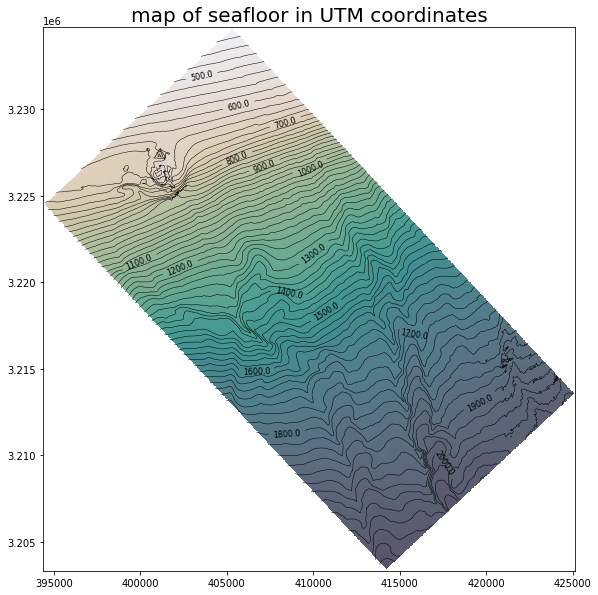

In [ ]:
from scipy.ndimage import rotate
z_rot = rotate(z, 43.1, reshape=True) # rotate map 43.1 degrees counterclockwise from N
z_rot[z_rot==0] = np.nan # replace zeros with nans to get white space in map
plt.figure(figsize=(10,10))
plt.imshow(z_rot, extent=[ulx, lrx, lly, ury], cmap=cmocean.cm.rain, alpha=0.75)
levels = np.arange(400, np.nanmax(z_rot), 25)
# I am not sure why the contours need to be flipped, but they do...
CS = plt.contour(z_rot[::-1,:], extent=[ulx, lrx, lly, ury], levels=levels, colors='k', linewidths=0.5)
plt.xlim(ulx, lrx)
plt.ylim(lly, ury)
# add labels to every 4th contourline:
ax.clabel(CS, levels[::4], inline=True, fmt='%1.1f', fontsize=8)
plt.title('map of seafloor in UTM coordinates', fontsize=20);

## Display faults

In [ ]:
# import CSV file that was exported from seismic interpretation package
url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/fault_export_example.csv'
df = pd.read_csv(url, names=['fault_name', 'inline', 'crossline', 'twt', 'stick_no', 'node_no'])
df.head()

fault_name  inline  crossline          twt  stick_no  node_no
0   Fault 10    1755       6647  1385.597136         0        0
1   Fault 10    1755       6644  1557.353943         0        1
2   Fault 10    1755       6643  1672.425821         0        2
3   Fault 10    1755       6640  1791.069284         0        3
4   Fault 10    1750       6646  1291.893044         1        0

In [ ]:
def plot_x_section_w_faults(vol, df, line_no, il_xl, min_il, min_xl):
    """function for plotting faults on seismic sections
    inputs:
    vol - numpy array containing seismic data
    df - data frame containing fault data
    line_no - line number to be displayed
    il_xl - decides whether an inline ('il') or crossline ('xl') is displayed
    min_il - minimum inline number in 'vol'
    min_xl - minimum crossline number in vol
    returns:
    fig - figure handle"""
    
    plt.figure(figsize = (10,15))
    if il_xl == 'il':
        im = plt.imshow(vol[line_no - min_il, :, :].T, cmap='RdBu', vmin=-2000, vmax=2000, aspect=0.5) 
        fault_names = df.loc[df.inline == line_no]['fault_name'].unique()
        for fault_name in fault_names:
            fault_x = df.loc[df.inline == line_no]['crossline'][df.fault_name == fault_name] - min_xl
            fault_y = 0.25*df.loc[df.inline == line_no]['twt'][df.fault_name == fault_name]
            plt.plot(fault_x, fault_y, 'b')
        plt.title('inline #' + str(line_no), fontsize=14)
        xticks = np.arange(0, n_xlines+1, 200)
    if il_xl == 'xl':
        im = plt.imshow(vol[:,line_no - min_xl,:].T, cmap='RdBu', vmin=-2000, vmax=2000, aspect=0.5)
        fault_names = df.loc[df.inline == line_no]['fault_name'].unique()
        for fault_name in fault_names:
            fault_x = df.loc[df.crossline == line_no]['inline'][df.fault_name == fault_name] - min_il
            fault_y = 0.25*df.loc[df.crossline == line_no]['twt'][df.fault_name == fault_name]
            plt.plot(fault_x, fault_y, 'b')
        xticks = np.arange(0, n_inlines+1, 200)
        plt.title('crossline #' + str(line_no), fontsize=20)
    xtick_labels = [str(25*t) for t in xticks]
    plt.xticks(ticks = xticks, labels = xtick_labels)
    plt.xlabel('distance (m)', fontsize=14)
    plt.colorbar(im, shrink=0.5)
    yticks = [0, 500, 1000, 1500, 2000]
    ytick_labels = [str(4*t) for t in yticks] # use list comprehension to get labels
    plt.yticks(ticks = yticks, labels = ytick_labels)
    plt.ylabel('two-way traveltime (ms)', fontsize=14)
    return fig

In [ ]:
len(df.inline.unique())

50

In [ ]:
len(df.crossline.unique())

237

In [ ]:
df.inline.unique()

array([1755, 1750, 1745, 1740, 1735, 1730, 1710, 1760, 1765, 1770, 1775,
       1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 2030, 2010, 1990,
       1985, 1980, 1975, 2015, 2005, 2000, 1995, 1970, 1965, 1960, 1955,
       1950, 1945, 1940, 1935, 1930, 1925, 1690, 1670, 1650, 1630, 1610,
       1590, 1570, 1550, 1530, 1510, 1490])

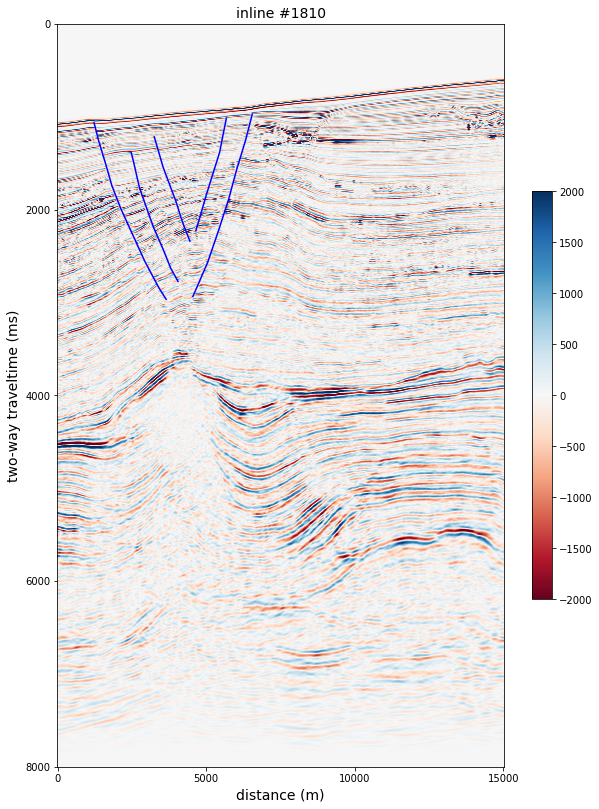

In [ ]:
fig = plot_x_section_w_faults(vol, df, 1810, 'il', min_il, min_xl)

## Create labeled volume for ML

In [ ]:
def create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl):
    h = np.zeros((n_inlines, n_xlines))
    for i in range(len(df)):
        il_ind = df['il'][i]
        xl_ind = df['xl'][i]
        # the inline indices need to be flipped:
        h[max_il - il_ind, xl_ind - min_xl] = df['z'][i]
    return h

def fill_in_surface(h):
    # fill in and despike the surface:
    zero_row, zero_col = np.where(h==0) # find locations where z = 0
    for i in range(len(zero_row)):
        if zero_col[i] == 0:
            patch = h[zero_row[i]-2 : zero_row[i]+3, zero_col[i] : zero_col[i]+3]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        elif zero_col[i] == 1:
            patch = h[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-1 : zero_col[i]+3]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        elif zero_col[i] == n_xlines-1:
            patch = h[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-3 : zero_col[i]]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        elif zero_col[i] == n_xlines-2:
            patch = h[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-3 : zero_col[i]+1]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        elif zero_row[i] == 0:
            patch = h[zero_row[i] : zero_row[i]+3, zero_col[i]-2 : zero_col[i]+3]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        elif zero_row[i] == 1:
            patch = h[zero_row[i]-1 : zero_row[i]+3, zero_col[i]-2 : zero_col[i]+3]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        elif zero_row[i] == n_inlines-1:
            patch = h[zero_row[i]-3 : zero_row[i], zero_col[i]-2 : zero_col[i]+3]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        elif zero_row[i] == n_inlines-2:
            patch = h[zero_row[i]-3 : zero_row[i]+1, zero_col[i]-2 : zero_col[i]+3]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
        else:
            patch = h[zero_row[i]-2 : zero_row[i]+3, zero_col[i]-2 : zero_col[i]+3]
            h[zero_row[i], zero_col[i]] = np.mean(patch[patch!=0])  # take the mean of nonzero neighbors
    return h

In [ ]:
%matplotlib inline

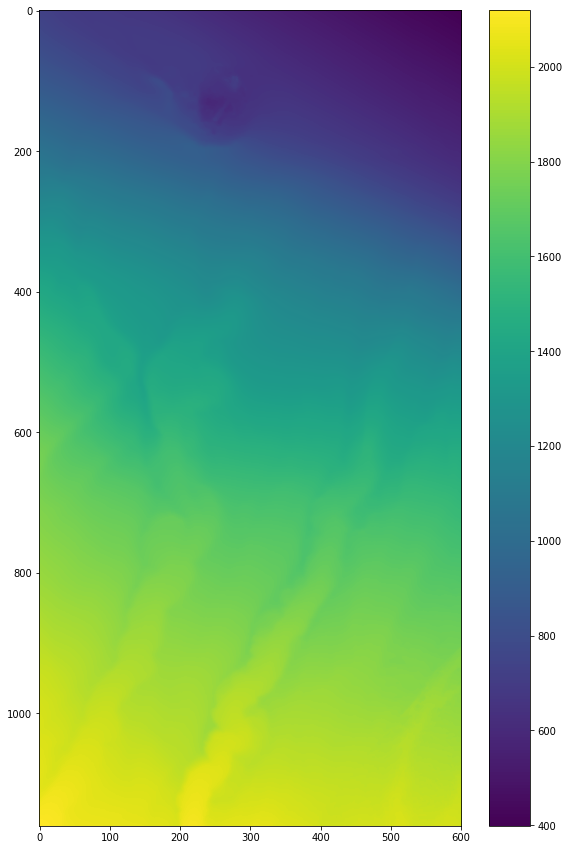

In [ ]:
url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_01.csv'
df = pd.read_csv(url, names=['il', 'xl', 'x', 'y', 'z'])
min_il = np.min(np.unique(df['il'])) # minimum inline number
max_il = np.max(np.unique(df['il'])) # maximum inline number
min_xl = np.min(np.unique(df['xl'])) # minimum crossline number
max_xl = np.max(np.unique(df['xl'])) # maximum crossline number
h1 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h1 = fill_in_surface(h1)
plt.figure(figsize = (10, 15))
plt.imshow(h1)
plt.colorbar();

In [ ]:
from skimage.measure import label

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_02.csv', names=['il', 'xl', 'x', 'y', 'z'])
h2 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h2[h2==0] = h1[h2==0] # fill in h2 with values from h1

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_03.csv', names=['il', 'xl', 'x', 'y', 'z'])
h3 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h3 = fill_in_surface(h3)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_04.csv', names=['il', 'xl', 'x', 'y', 'z'])
h4 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h4 = fill_in_surface(h4)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_05.csv', names=['il', 'xl', 'x', 'y', 'z'])
h5 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h5 = fill_in_surface(h5)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_06.csv', names=['il', 'xl', 'x', 'y', 'z'])
h6 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h6 = fill_in_surface(h6)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_07.csv', names=['il', 'xl', 'x', 'y', 'z'])
h7 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h7 = fill_in_surface(h7)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_08.csv', names=['il', 'xl', 'x', 'y', 'z'])
h8 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h8 = fill_in_surface(h8)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_08a.csv', names=['il', 'xl', 'x', 'y', 'z'])
h8a = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h8a[h8a==0] = h8[h8a==0] # fill in h8a with values from h8

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_09.csv', names=['il', 'xl', 'x', 'y', 'z'])
h9 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h9 = fill_in_surface(h9)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_08b.csv', names=['il', 'xl', 'x', 'y', 'z'])
h8b = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
temp = h8b.copy()
temp[temp>0] = 1
temp[temp==0] = 2
temp_label = label(temp)
h8b[temp_label==1] = h8[temp_label==1]
h8b[temp_label==3] = h9[temp_label==3] 

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_08c.csv', names=['il', 'xl', 'x', 'y', 'z'])
h8c = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h8c[h8c==0] = h8a[h8c==0] # fill in h8c with values from h8a

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_10.csv', names=['il', 'xl', 'x', 'y', 'z'])
h10 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h10 = fill_in_surface(h10)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/horizon_11.csv', names=['il', 'xl', 'x', 'y', 'z'])
h11 = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
h11 = fill_in_surface(h11)

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/top_salt.csv', names=['il', 'xl', 'x', 'y', 'z'])
top_salt = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)
top_salt[top_salt == 0] = 2010

df = pd.read_csv('https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/base_salt.csv', names=['il', 'xl', 'x', 'y', 'z'])
base_salt = create_grid_from_xyz_data(df, n_inlines, n_xlines, max_il, min_xl)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Create facies volume

### Facies key
* 0 - WATER - water
* 1 - LAC - low amplitude continuous (slope mudstones)
* 2 - HAC - high amplitude continuous (slope mudstones)
* 3 - CLS - channel-levee system (overbank mudstones with silt layers and sandier channel deposits)
* 4 - LACSW - low amplitude continuous, with sediment waves (slope mudstones)
* 5 - MTC - chaotic (mass transport complex)
* 6 - LADC - low amplitude discontinuous (slope mudstones with some slides / mass transport deposits)
* 7 - HACLAT - high amplitude continuous to low amplitude transparent (slope mudstones)
* 8 - UNLABELED - unlabeled
* 9 - SALT - salt

### Facies distribution
* above H1: WATER 0
* H1 - H2: LAC 1
* H2 - H3: HAC 2
* H3 - H4: CLS 3
* H4 - H5: HAC 2
* H5 - H6: LACSW 4
* H6 - H7: LAC 1
* H7 - H8: MTC 5
* H8 - H8a: MTC 5
* H8 - H8c: LAC 1
* H8c - H9, H8b - H9, H8c - H9: LADC 6
* H8 - H8b: MTC 5
* H9 - H10: HACLAT 7
* H10 - H11: MTC 5
* below H11: UNLABELED 8
* Top salt - Base salt: SALT 9

In [ ]:
n_inlines

1161

In [ ]:
n_xlines

601

In [ ]:
np.shape(vol)

(1161, 601, 2001)

In [ ]:
import numpy as np
facies1 = np.zeros(np.shape(vol))
inds = np.arange(nt)
for i in range(n_inlines):
    for j in range(n_xlines):
        facies1[i, j, :][(inds >= h1[n_inlines-1-i,j]/4) & (inds < h2[n_inlines-1-i,j]/4)] = 1 # LAC
        facies1[i, j, :][(inds >= h2[n_inlines-1-i,j]/4) & (inds < h3[n_inlines-1-i,j]/4)] = 2
        facies1[i, j, :][(inds >= h3[n_inlines-1-i,j]/4) & (inds < h4[n_inlines-1-i,j]/4)] = 3
        facies1[i, j, :][(inds >= h4[n_inlines-1-i,j]/4) & (inds < h5[n_inlines-1-i,j]/4)] = 2
        facies1[i, j, :][(inds >= h5[n_inlines-1-i,j]/4) & (inds < h6[n_inlines-1-i,j]/4)] = 4
        facies1[i, j, :][(inds >= h6[n_inlines-1-i,j]/4) & (inds < h7[n_inlines-1-i,j]/4)] = 1
        facies1[i, j, :][(inds >= h7[n_inlines-1-i,j]/4) & (inds < h8[n_inlines-1-i,j]/4)] = 5 
        facies1[i, j, :][(inds >= h8[n_inlines-1-i,j]/4) & (inds < h8a[n_inlines-1-i,j]/4)] = 5 # MTD
        facies1[i, j, :][(inds >= h8[n_inlines-1-i,j]/4) & (inds >= h8a[n_inlines-1-i,j]/4) & (inds < h8c[n_inlines-1-i,j]/4)] = 1
        facies1[i, j, :][(inds >= h8c[n_inlines-1-i,j]/4) & (inds >= h8b[n_inlines-1-i,j]/4) & (inds < h9[n_inlines-1-i,j]/4)] = 6
        facies1[i, j, :][(inds >= h8[n_inlines-1-i,j]/4) & (inds >= h8c[n_inlines-1-i,j]/4) & (inds < h8b[n_inlines-1-i,j]/4)] = 5 # MTD
        facies1[i, j, :][(inds >= h9[n_inlines-1-i,j]/4) & (inds < h10[n_inlines-1-i,j]/4)] = 7
        facies1[i, j, :][(inds >= h10[n_inlines-1-i,j]/4) & (inds < h11[n_inlines-1-i,j]/4)] = 5
        #facies1[i, j, :][inds >= h11[n_inlines-1-i,j]/4] = 8 # unlabeled
        facies1[i, j, :][(inds >= top_salt[n_inlines-1-i,j]/4) & (inds < base_salt[n_inlines-1-i,j]/4)] = 9 # salt

In [ ]:
facies1.shape

(1161, 601, 2001)

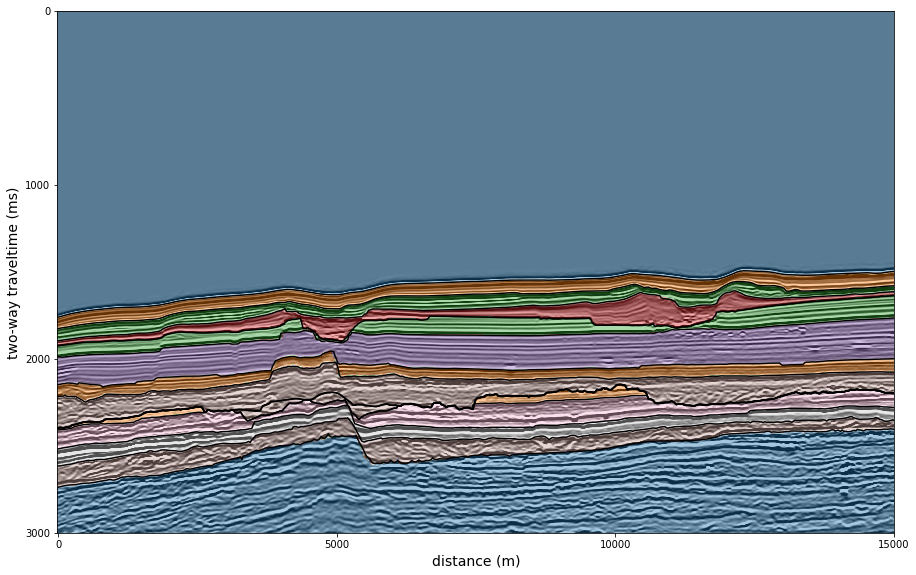

In [ ]:
plt.figure(figsize=(15,10))
inline_no = 500
im = plt.imshow(vol[inline_no, :, :].T, cmap='gray', vmin=-1000, vmax=1000, aspect=0.5)
plt.imshow(facies1[inline_no,:,:].T, aspect=0.5, alpha=0.4, cmap='tab20', vmin = 0, vmax = 9)
yticks = [0, 250, 500, 750, 951]
ytick_labels = [str(4*t) for t in yticks] # use list comprehension to get labels
plt.yticks(ticks = yticks, labels = ytick_labels)
plt.ylabel('two-way traveltime (ms)', fontsize=14)
xticks = [0, 200, 400, 600]
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
plt.xlabel('distance (m)', fontsize=14)
# plt.colorbar(im, shrink=0.5) # use the 'shrink' parameter to avoid creating a very large colorbar

for horizon in [h1, h2, h3, h4, h5, h6, h7, h8, h8a, h8b, h8c, h9, h10, h11]:
    plt.plot(horizon[1161-inline_no, :]/4, 'k')
    
plt.ylim(750, 0);

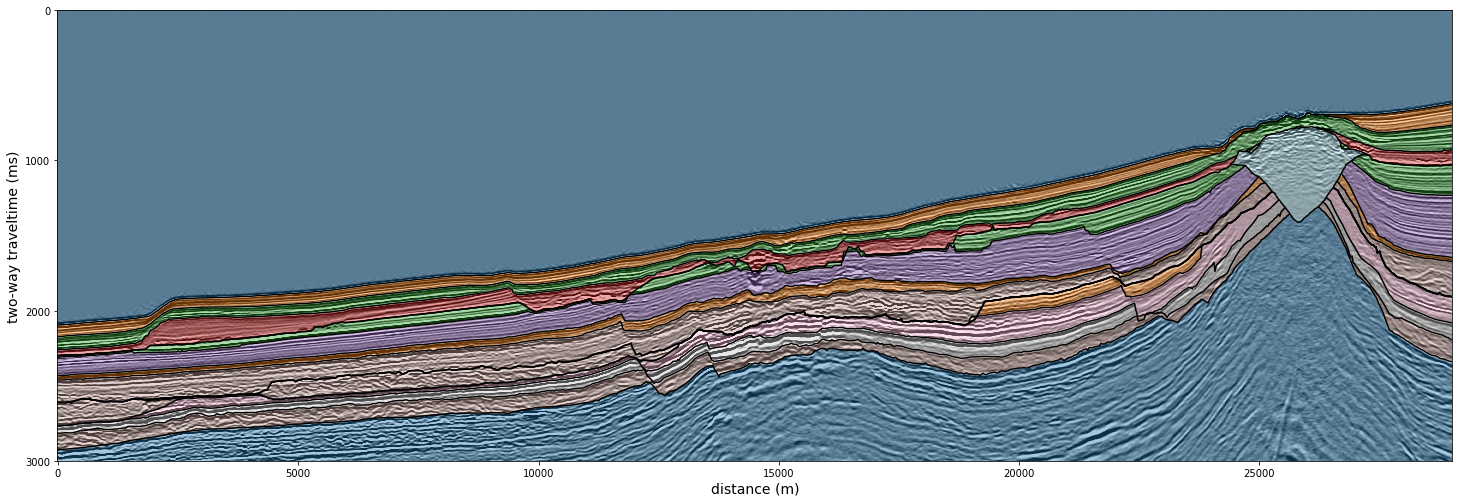

In [ ]:
plt.figure(figsize=(25,10))
crossline_no = 220
im = plt.imshow(vol[:, crossline_no, :].T, cmap='gray', vmin=-1000, vmax=1000, aspect=0.5)
plt.imshow(facies1[:,crossline_no,:].T, aspect=0.5, alpha=0.4, cmap='tab20', vmin = 0, vmax = 9)
yticks = [0, 250, 500, 750]
ytick_labels = [str(4*t) for t in yticks] # use list comprehension to get labels
plt.yticks(ticks = yticks, labels = ytick_labels)
plt.ylabel('two-way traveltime (ms)', fontsize=14)
xticks = np.arange(0, n_inlines+1, 200)
xtick_labels = [str(25*t) for t in xticks]
plt.xticks(ticks = xticks, labels = xtick_labels)
plt.xlabel('distance (m)', fontsize=14)
plt.ylim(750, 0);

horizons = [h1, h2, h3, h4, h5, h6, h7, h8, h8a, h8b, h8c, h9, h10, h11, top_salt, base_salt]

ts = horizons[14][:, crossline_no-601][::-1]/4 # top salt
ts[ts == 2010/4] = np.nan
plt.plot(ts, 'k');
bs = horizons[15][:, crossline_no-601][::-1]/4 # base salt
bs[bs == 0] = np.nan
plt.plot(bs, 'k');

for i in range(14):
    h = horizons[i][:, crossline_no-601][::-1]/4
    h[(h > ts) & (h < bs)] = np.nan
    plt.plot(h, 'k');

## Task 1

* Read the seismic data into a notebook and display one inline and one crossline.
* Make a shaded relief map from one of the horizons above (named horizon_01, horizon_02, ...) with contours. Choose a horiozn that extends over most of the seismic volume.

## Task 2

In theory we have one potential predictor (seismic amplitude) and a target label (seismic facies). Select a small subset of the data (both seismic amplitude and facies samples) to check how different are the amplitude values between the different facies. Filter out facies 0 (water) and 8 (unlabeled). Use the ['displot' function](https://seaborn.pydata.org/generated/seaborn.displot.html) in 'kde' mode to compare the amplitude distributions. Are the amplitude values different enough across the facies classes to give any hope for a reasonably good classification model?

## Task 3

The main reason why the approach at Task 2 doesn't work is that seismic facies are defined not based on a single value, but they take into account the overall patterns in a larger patch / volume of seismic data surrounding the sample under consideration.

* Extract a series of amplitude values within a window of n (e.g., 10 or 20) samples around a seismic sample.
* Compute the mean and the standard deviation of this set of amplitude values.
* Do this for a subset of the data (e.g., 200 seismic traces / a few tens of thousands of samples) and store the seismic amplitude, facies, mean amplitude, and standard deviation values in a dataframe. Filter out facies 0 (water) and 8 (unlabeled).
* Create a training and test set and use amplitude, mean amplitude, and standard deviation of amplitude to predict facies, using a random forest classifier.
* What is the accuracy score? Is this a potentially useful model?

## Bonus task

Using the model you built in Task 3, classify part of one seismic section and display the result as a section colored by facies. Is this a useful prediction?

### Task2

In [ ]:
type(facies1)
print("Array dimensions:", facies1.shape) 
facies1

Array dimensions: (1161, 601, 2001)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
facies1_first_100 = facies1[:, :, :100]

In [ ]:
if np.any(facies1_first_100):
    print("There are nonzero elements in the array")
else:
    print("All elements in the array are zero")

All elements in the array are zero


In [ ]:
# create a mask to filter out 0 and 8
mask = np.logical_and(facies1_first_100 > 0, facies1_first_100 != 8)

# apply the mask to the seismic facies array
filtered_facies = np.where(mask, facies1_first_100, np.nan)

In [ ]:
type(filtered_facies)
print("Array dimensions:", filtered_facies.shape) 
filtered_facies

Array dimensions: (1161, 601, 100)


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [ ]:
facies1_first_100 = facies1[:, :, :100]
print("Array dimensions:", facies1_first_5.shape)
facies1_first_1

Array dimensions: (1161, 601, 1)


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [ ]:
print(facies1_first_5)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


In [ ]:
type(h1)

numpy.ndarray

In [ ]:
print("Array dimensions:", h1.shape)

Array dimensions: (1161, 601)


In [ ]:
h1_3d = np.expand_dims(h1, axis=2)
print("Array dimensions:", h1_3d.shape)

Array dimensions: (1161, 601, 1)


In [ ]:
subset = np.concatenate((facies1_first_100, h1_3d), axis=2)
print("Array dimensions:", subset)

Array dimensions: [[[   0.         0.         0.      ...    0.         0.             nan]
  [   0.         0.         0.      ...    0.         0.       888.36774]
  [   0.         0.         0.      ...    0.         0.       891.34406]
  ...
  [   0.         0.         0.      ...    0.         0.       503.29636]
  [   0.         0.         0.      ...    0.         0.       502.60449]
  [   0.         0.         0.      ...    0.         0.       501.54935]]

 [[   0.         0.         0.      ...    0.         0.       887.41614]
  [   0.         0.         0.      ...    0.         0.       892.18884]
  [   0.         0.         0.      ...    0.         0.       894.18433]
  ...
  [   0.         0.         0.      ...    0.         0.       504.07526]
  [   0.         0.         0.      ...    0.         0.       503.58832]
  [   0.         0.         0.      ...    0.         0.       503.12524]]

 [[   0.         0.         0.      ...    0.         0.       892.92163]
  [ 

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load data into a pandas DataFrame
#data = pd.read_csv('your_data_file.csv')

# Filter out facies 0 (water) and 8 (unlabeled)
#data = data[data['seismic facies'].isin([1, 2, 3, 4, 5, 6, 7])]

# Select a small subset of the data
#subset = data.sample(n=100)

# Extract the seismic amplitude and seismic facies columns
#amplitude = subset['seismic amplitude']
#facies = subset['seismic facies']

# Plot a histogram with KDE for each seismic facies
sns.displot(subset, kde=True, multiple='stack')

# Set the title and axis labels
plt.title('Seismic Amplitude Distribution by Seismic Facies')
plt.xlabel('Seismic Amplitude')
plt.ylabel('Frequency')

# Display the plot
plt.show()

ValueError: ignored

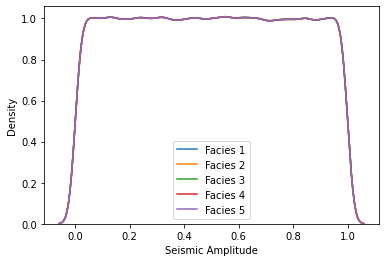

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# create a sample array with dimensions (1161, 601, 5)
seismic_facies = np.random.rand(1161, 601, 5)

# create a sample array with dimensions (1161, 601)
seismic_amplitude = np.random.rand(1161, 601)

# create a list of facies names
facies_names = ["Facies " + str(i+1) for i in range(seismic_facies.shape[2])]

# create a dictionary of facies data with facies names as keys
facies_data = {facies_names[i]: seismic_amplitude[seismic_facies[:,:,i] > 0] for i in range(seismic_facies.shape[2])}

# create a kde plot for each facies
for i in range(seismic_facies.shape[2]):
    sns.kdeplot(facies_data[facies_names[i]], label=facies_names[i])

# set the x-axis label and legend
plt.xlabel("Seismic Amplitude")
plt.legend()

# display the plot
plt.show()

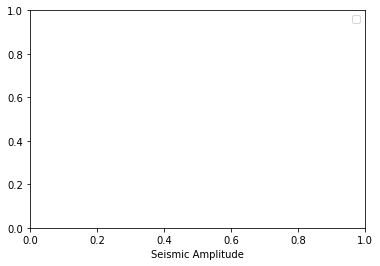

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# create a sample array with dimensions (1161, 601, 5)
seismic_facies = facies1[:, :, :5]

# create a sample array with dimensions (1161, 601)
seismic_amplitude = h1

# create a list of facies names
facies_names = ["Facies " + str(i+1) for i in range(seismic_facies.shape[2])]

# create a dictionary of facies data with facies names as keys
facies_data = {facies_names[i]: seismic_amplitude[seismic_facies[:,:,i] > 0] for i in range(seismic_facies.shape[2])}

# create a kde plot for each facies
for i in range(seismic_facies.shape[2]):
    sns.kdeplot(facies_data[facies_names[i]], label=facies_names[i])

# set the x-axis label and legend
plt.xlabel("Seismic Amplitude")
plt.legend()

# display the plot
plt.show()

Text(-2.700000000000003, 0.5, 'Density')

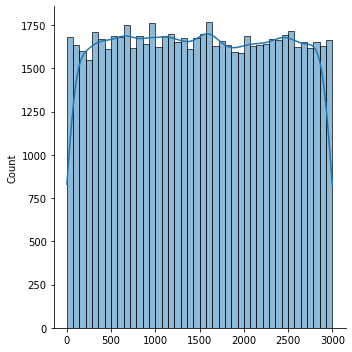

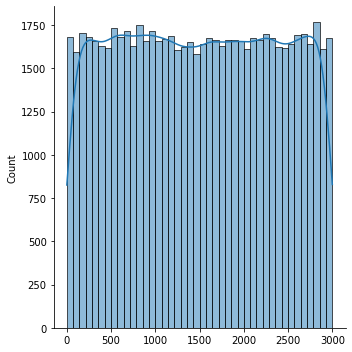

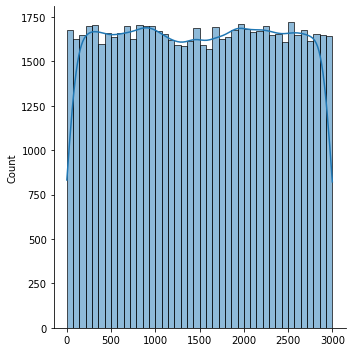

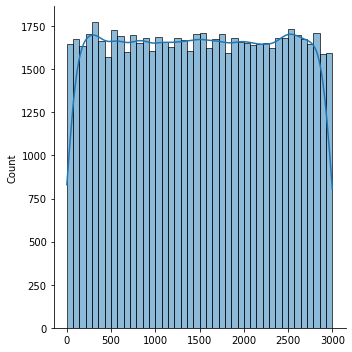

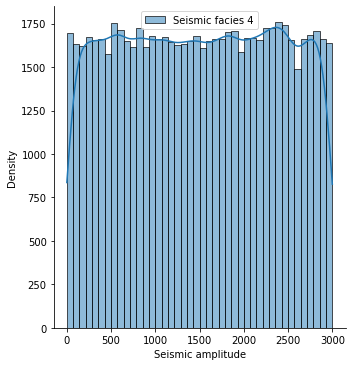

In [ ]:
import seaborn as sns
import numpy as np

# generate some example data
seismic_facies = np.random.randint(0, 10, size=(1161, 601, 5))
seismic_amplitude = np.random.randint(0, 3001, size=(1161, 601))

# reshape seismic facies to a 2D array
seismic_facies_2d = seismic_facies.reshape(-1, 5)

# create a list of labels for each seismic facies
facies_labels = [f"Seismic facies {i}" for i in range(5)]

# create a displot for each seismic facies
for i in range(5):
    sns.displot(seismic_amplitude[seismic_facies[..., i] == 1],
                kde=True,
                label=facies_labels[i],
                alpha=0.5)

# add a legend and axis labels
plt.legend()
plt.xlabel("Seismic amplitude")
plt.ylabel("Density")

In [ ]:
print(seismic_facies)
print(seismic_amplitude)

[[[2 1 9 2 6]
  [7 1 5 8 2]
  [5 8 1 3 6]
  ...
  [9 0 1 9 7]
  [1 3 4 3 3]
  [5 4 3 9 0]]

 [[3 3 2 0 5]
  [2 3 1 0 7]
  [4 1 5 3 8]
  ...
  [5 1 5 6 8]
  [7 1 6 0 0]
  [9 9 0 1 5]]

 [[0 8 8 4 3]
  [8 4 4 9 6]
  [8 1 8 8 3]
  ...
  [5 4 9 0 3]
  [3 2 3 1 6]
  [4 9 4 2 0]]

 ...

 [[3 3 7 0 6]
  [9 1 7 9 2]
  [5 2 8 8 7]
  ...
  [2 1 9 2 0]
  [2 2 0 6 3]
  [3 8 4 9 0]]

 [[6 2 0 6 2]
  [5 5 4 5 4]
  [5 3 9 8 3]
  ...
  [2 8 1 5 7]
  [1 7 6 9 7]
  [3 7 4 7 4]]

 [[6 2 4 8 0]
  [3 3 8 3 3]
  [3 9 4 6 0]
  ...
  [6 8 6 9 5]
  [8 4 2 1 4]
  [9 1 8 7 1]]]
[[1587 1414 1851 ... 2767  980  912]
 [ 308 1051 1303 ...  488 1709  241]
 [ 576 2994 1846 ... 2725 1770 1832]
 ...
 [ 873 1787  374 ... 1124  710  335]
 [1995 2959 2882 ... 2689  382 2025]
 [2023 2704 1473 ... 1307 2453 2627]]


In [ ]:
print(facies1[:, :, :5])
print(h1)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
[[       nan  888.36774  891.34406 ...  503.29636  502.60449  501.54935]
 [ 887.41614  892.18884  894.18433 ...  504.07526  503.58832  503.12524]
 [ 892.92163  895.6991   896.51459 ...  505.20193  504.48511  504.01682]
 ...
 [2187.19336 2186.97681 2186.51685 ...

###TASK3

In [7]:
!wget https://www.dropbox.com/s/vor6d4oswqha443/facies_data.npz

data = np.load('facies_data.npz')

--2023-02-21 17:57:26--  https://www.dropbox.com/s/vor6d4oswqha443/facies_data.npz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/vor6d4oswqha443/facies_data.npz [following]
--2023-02-21 17:57:26--  https://www.dropbox.com/s/raw/vor6d4oswqha443/facies_data.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7d0c70d49e62737c9d6c8a0189.dl.dropboxusercontent.com/cd/0/inline/B25DXcYhFryyBbxu_hNsSYS-7KmHUTPWj2VmVb7xO6HeaJGHhTSln8815GDy4pznev6JxzT25we8PH6F6ngd317RjZmslVtITjbZky9rRLj-0_FD7jcG1ei4-RRGV4asfjkq8Vy8a65mbCRN91xh1xy9HVyAp7BCyurYP2wPSDPY9w/file# [following]
--2023-02-21 17:57:26--  https://uc7d0c70d49e62737c9d6c8a0189.dl.dropboxusercontent.com/cd/0/inline/B25DXcYhFryyBbxu_hNsSYS-7KmHUTPWj2VmVb7xO6HeaJGHhTSln8815GDy4pznev6JxzT

In [93]:
from tqdm import trange

s_traces = np.array([])

f_traces = np.array([])

mean_amps = np.array([])

std_amps = np.array([])

for j in trange(200, 250):

    s_trace = data['seismic'][100, j, 100:-100]

    f_trace = data['facies'][100, j, 100:-100][10:-10]

    mean_amp = np.array([np.mean(s_trace[i-10 : i+10]) for i in range(10, len(s_trace)-10)])

    std_amp = np.array([np.std(s_trace[i-10 : i+10]) for i in range(10, len(s_trace)-10)])

    s_traces = np.hstack((s_traces, s_trace[10:-10]))

    f_traces = np.hstack((f_traces, f_trace))

    mean_amps = np.hstack((mean_amps, mean_amp))

    std_amps = np.hstack((std_amps, std_amp))

100%|██████████| 50/50 [03:00<00:00,  3.61s/it]


In [94]:
import numpy as np

# create numpy arrays Y and X

# boolean indexing to filter out 0 and 8 values in Y
mask = (f_traces != 0) & (f_traces != 8)
f_traces = f_traces[mask]
s_traces = s_traces[mask]
mean_amps = mean_amps[mask]
std_amps = std_amps[mask]

# print the shapes of the filtered arrays
print("f_traces shape:", f_traces.shape)
print("s_traces shape:", s_traces.shape)
print("mean_amps shape:", mean_amps.shape)
print("std_amps shape:", std_amps.shape)

f_traces shape: (8453,)
s_traces shape: (8453,)
mean_amps shape: (8453,)
std_amps shape: (8453,)


In [95]:
type(s_traces)

numpy.ndarray

In [96]:
s_traces.shape

(8453,)

In [97]:
mean_amps.shape

(8453,)

In [98]:
std_amps.shape

(8453,)

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(s_traces, f_traces, random_state=42)
mean_train, mean_test, std_train, std_test = train_test_split(mean_amps, std_amps, random_state=42)

In [100]:
X_train.shape

(6339,)

In [101]:
X_test.shape

(2114,)

In [102]:
X_train_reshaped = X_train.reshape(-1, 1)
X_test_reshaped = X_test.reshape(-1, 1)
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)
mean_train_reshaped = mean_train.reshape(-1, 1)
mean_test_reshaped = mean_test.reshape(-1, 1)
std_train_reshaped = std_train.reshape(-1, 1)
std_test_reshaped = std_test.reshape(-1, 1)

In [103]:
X_train_combined = np.concatenate((X_train_reshaped, mean_train_reshaped, std_train_reshaped), axis=1)
X_test_combined = np.concatenate((X_test_reshaped, mean_test_reshaped, std_test_reshaped), axis=1)

In [104]:
X_train_combined.shape

(6339, 3)

In [105]:
X_test_combined.shape

(2114, 3)

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)


In [107]:
rnd_clf.fit(X_train_combined, y_train_reshaped)

<ipython-input-107-fe7edbbf6003>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf.fit(X_train_combined, y_train_reshaped)


RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, random_state=42)

In [108]:
y_pred_rf = rnd_clf.predict(X_test_combined)

In [109]:
accuracy_score(y_test_reshaped, y_pred_rf)

0.4692526017029328